# Introduction

Author: Wolfgang Pfaff <wolfgang.pfaff@microsoft.com>

This version: August 13, 2018.

This document is to illustrate which kind of data we are and will be interested when developing and characterizing qubits. The aim is to ignore the microscopic details, and just focus on the structure of the data. 

All presented ways to look at the data are very helpful for checking the validity of the data while they are being acquired (although I haven't yet included a specific overview of 'bad' things that can be spotted like this). We would therefore like to have appropriate tools available in live plotting solutions.

For the moment i use as an example(!) a simple single-qubit readout experiment. The basic ideas hold for other experiments as well, though. However, since this is where we need to go with our experiments, i feel this is a good guideline for what experiments need to be supported. I will make additions to this document over time.

# Initialization and tools

In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

## Qubit readout

In [2]:
class QubitReadout:
    """
    A simple mock-up of how qubit readout data should look.
    What it represents is outlined in the markup of this notebook.
    """
    
    pos0 = -1
    pos1 = 1
    sigma = 0.5
    
    def __init__(self, p0=1, rabi_angle=None):
        self.p0 = p0
        if rabi_angle is not None:
            self.p0 = .5 + .5*np.cos(rabi_angle)
    
    def readout_results(self, n):
        n0 = int(n * self.p0)
        if n0 > 0:
            zeros = np.random.normal(loc=[self.pos0.real, self.pos0.imag], 
                                     scale=self.sigma, size=(n0, 2))
            zeros = zeros[:,0] + 1j*zeros[:,1]
        else:
            zeros = np.array([])
        
        if n-n0 > 0:
            ones = np.random.normal(loc=[self.pos1.real, self.pos1.imag], 
                                    scale=self.sigma, size=(n-n0, 2))
            ones = ones[:,0] + 1j*ones[:,1]
        else:
            ones = np.array([])
        
        results = np.random.permutation(np.concatenate((zeros, ones)))
        return results

# Qubit readout

## Introduction

A lot of the data we are eventually interested in is composed of samples of complex numbers, where each samples represents one readout result or 'event'. Meaningful physical quantities can then be reconstructed by looking at properties of the ensemble --- e.g., the mean of the phase/magnitude/... --- as function of external parameters.

An important role is eventually played by the distribution the samples take in the complex (IQ) plane. To illustrate this, let's consider the readout of a qubit by means of a radiofrequency (RF) signal. In such a measurement we send a RF signal to the sample, and extract amplitude and phase (i.e., a complex number) of the returned signal. We then repeat this measurement to build up statistics. The experiment is typically set up such that measurement of the qubit states $|0\rangle$ and $|1\rangle$ results in two distinct distributions in the IQ plane; the position of the distributions are given by the readout circtuitry and how it is coupled to the qubit, and the width and shape most often by the noise in the system. 

As an example, this is how the readout of a qubit that has equal probability of being in $|0\rangle$ and $|1\rangle$ might look. To visualize, we simulate 10000 measurement 'shots', and plot a histogram of the results:

<IPython.core.display.Javascript object>


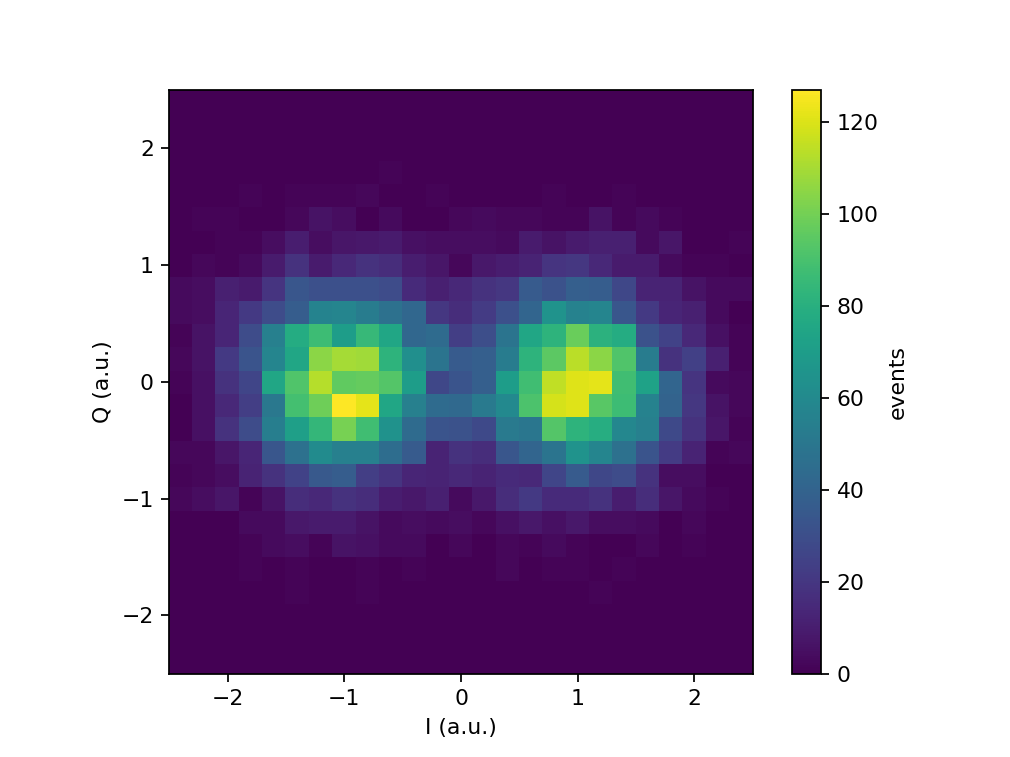

In [3]:
ro = QubitReadout(p0=0.5) # set the 0/1 probabilities to 0.5
samples = ro.readout_results(n=10000) # get 10k readout events
h, xe, ye = np.histogram2d(samples.real, samples.imag, bins=np.linspace(-2.5, 2.5, 26)) # histogram the results

fig, ax = plt.subplots(1, 1)
im = ax.pcolormesh(xe, ye, h.T)
ax.set_aspect('equal')
cb = fig.colorbar(im)
ax.set_xlabel('I (a.u.)')
ax.set_ylabel('Q (a.u.)')
cb.set_label('events')

In this example we have chosen the parameters such the two states give easily distinguishable distributions; the left 'blob' corresponds to events where we have found the qubit in $|0\rangle$, and the right one to events where it was in $|1\rangle$. in fact these parameters are very close to what is routinely achievable in several qubit implementations.

## Example: Rabi oscillations

To see how we can use these data when extracting information about the qubit let's consider a so-called Rabi experiment, where we make the qubit oscillate between its two basis states. What we'd like to measure is the probability of the qubit being in the $|1\rangle$ state, as a function of the rotation angle. 

As we see from the two distributions above, a good proxy for this is actually the real part of the readout signal:

<IPython.core.display.Javascript object>


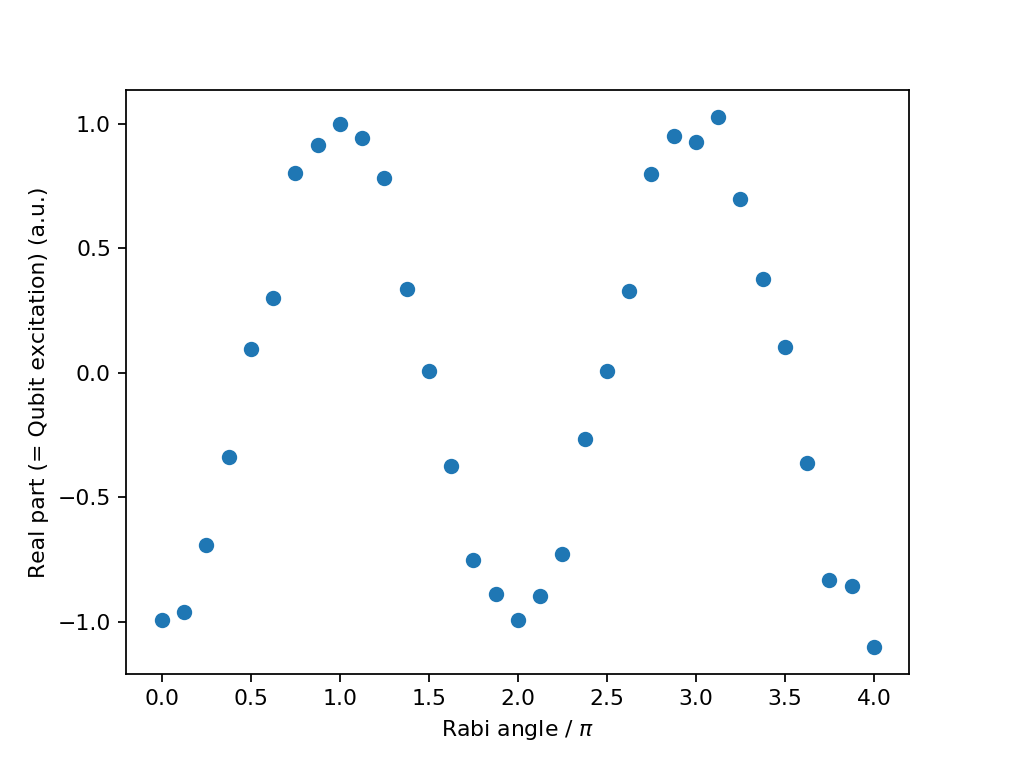

Text(0,0.5,'Real part (= Qubit excitation) (a.u.)')

In [4]:
nsamples = 100 # how many measurements per setpoint
rabi_angles = np.linspace(0, 4*np.pi, 33) # rotation angles (the setpoints)
samples = np.zeros((rabi_angles.size, nsamples), dtype=np.complex) # allocate array for results

for i, r in enumerate(rabi_angles): # simulate data for each setpoint
    ro = QubitReadout(rabi_angle=r)
    samples[i,:] = ro.readout_results(nsamples)
    
fig, ax = plt.subplots(1,1)
ax.plot(rabi_angles/np.pi, samples.mean(axis=1).real, 'o') # plot the proxy-signal, i.e, the real of the mean.
ax.set_xlabel(r"Rabi angle / $\pi$")
ax.set_ylabel("Real part (= Qubit excitation) (a.u.)")

There are of course ways to extract the actual probability. In our example, the optimal way is to define a threshold; since our case is symmetric around zero, the best we can do is to take all events left of zero as '0's and all events to the right as '1's. Simply from counting we can get the best possible guess for the qubit excitation probability:

<IPython.core.display.Javascript object>


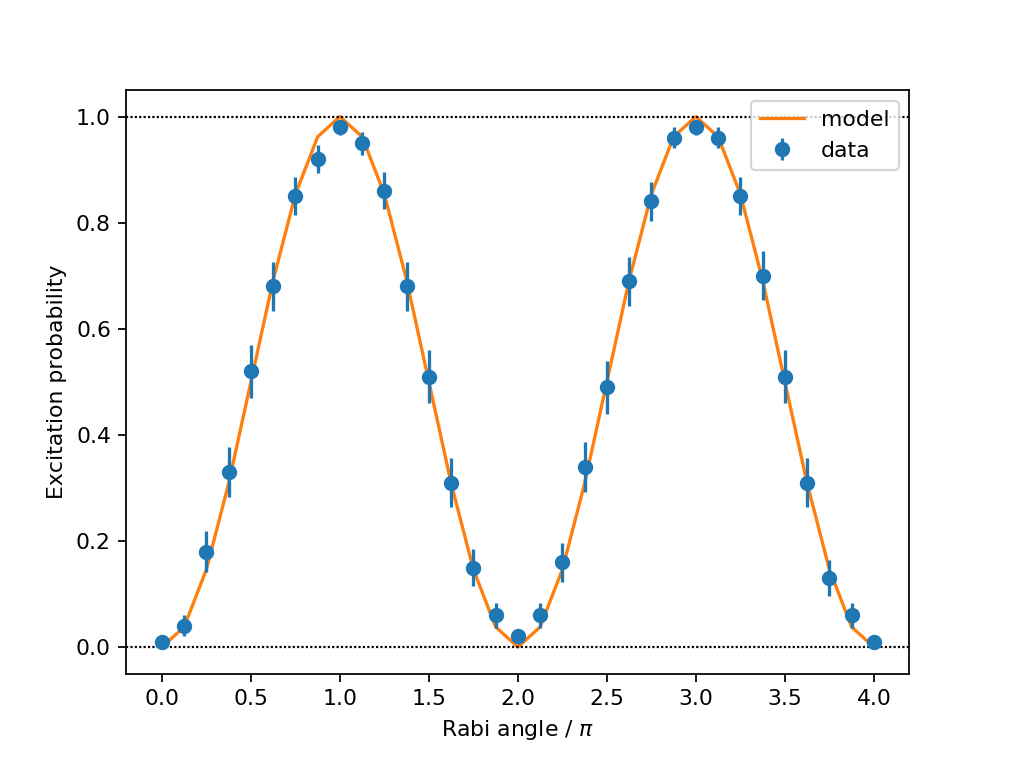

In [5]:
p_data = np.zeros_like(rabi_angles)
err_data = np.zeros_like(rabi_angles)
ideal_rabi = 0.5 - 0.5 * np.cos(rabi_angles) # how the probabilities would ideally look

for i in range(rabi_angles.size): # compute probability of the real part being left/right of 0
    p_data[i] = np.where(samples[i,:].real > 0)[0].size / float(nsamples)
    err_data[i] = ((p_data[i] * (1.-p_data[i]))/nsamples)**.5 # statistical uncertainties (from binomial distribution) 


fig, ax = plt.subplots(1,1)
ax.errorbar(rabi_angles/np.pi, p_data, yerr=err_data, fmt='o',
            label='data')
ax.plot(rabi_angles/np.pi, ideal_rabi, '-', zorder=0,
        label='model')

ax.set_xlabel(r"Rabi angle / $\pi$")
ax.set_ylabel("Excitation probability")
ax.axhline(0, color='k', lw=1, dashes=[1,1])
ax.axhline(1, color='k', lw=1, dashes=[1,1])
ax.legend(loc='upper right')

This representation looks very similar, but has actual physical meaning now. Note also that the probabilities are not exactly equal to a re-scaling of the real of the mean, since thresholding is not a linear operation.

When we look now at the histograms for two well chosen points on the curve, we see clearly that the distributions are very distinct.

<IPython.core.display.Javascript object>


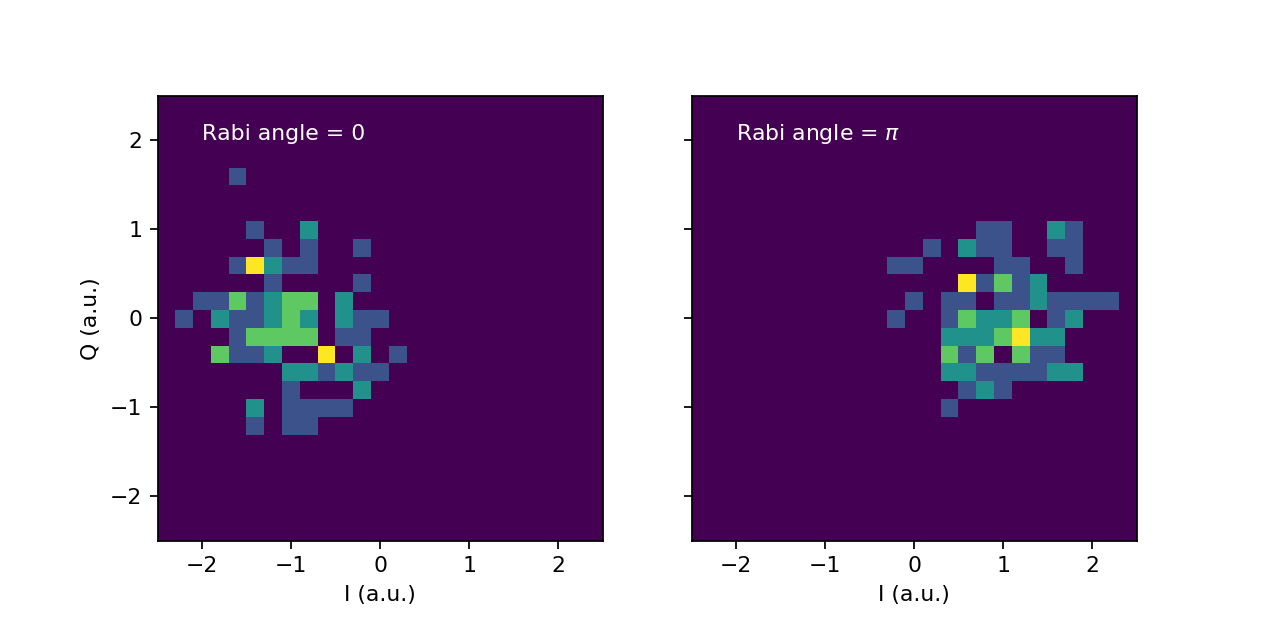

Text(-2,2,'Rabi angle = $\\pi$')

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
for idx, ax in zip([0, 8], axes):
    h, xe, ye = np.histogram2d(samples[idx, :].real, samples[idx, :].imag, 
                               bins=np.linspace(-2.5, 2.5, 26)) # histogram the results
    im = ax.pcolormesh(xe, ye, h.T)
    ax.set_aspect('equal')
    ax.set_xlabel('I (a.u.)')
    
axes[0].set_ylabel('Q (a.u.)')
axes[0].text(-2, 2, 'Rabi angle = 0', color='w')
axes[1].text(-2, 2, r'Rabi angle = $\pi$', color='w')

## Data accumulation and update of visualization

### Measuring setpoint by setpoint

The most straightforward way of measuring is to simply iterate through all setpoints, and integrate the data setpoint by setpoint. This is sufficiently captured in a lot of qcodes examples at this point, so i will not dive into any details here. 

More importantly, this is a particularly undesirable way of accumulating data when experiments reach a certain level of sophistication (in short: this method tends to be slow, and fairly susceptible to noise). A better way is to average over the whole, fast-executed measurement loop.

### Measuring repetition by repetition

A common way (in fact, the most desirable one for a lot of qubit experiments) of accumulating data is to have averaging as the most outer loop in the experiment. I.e., we measure a single 'shot' for each setpoint in some order, and then keep on repeating the experiment until we are happy with the signal to noise ratio (SNR) of the averaged data. Generally we like performing this averaging to some degree in software to be able to monitor the experiment; in contrast, I'll assume that all the setpoints are in some way controlled by hardware, which typically means in practice that we get our data in chunks that have the shape of the space of all setpoints.

The way the data then gradually 'clears up' to us looks like this:

<IPython.core.display.Javascript object>


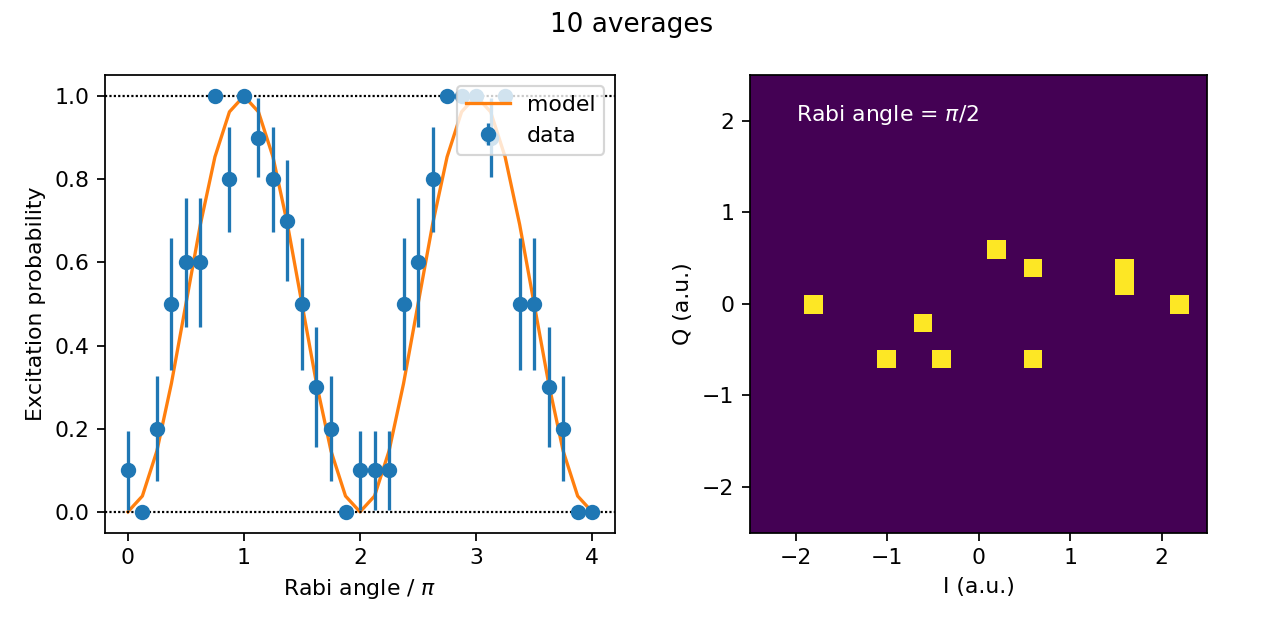

<IPython.core.display.Javascript object>


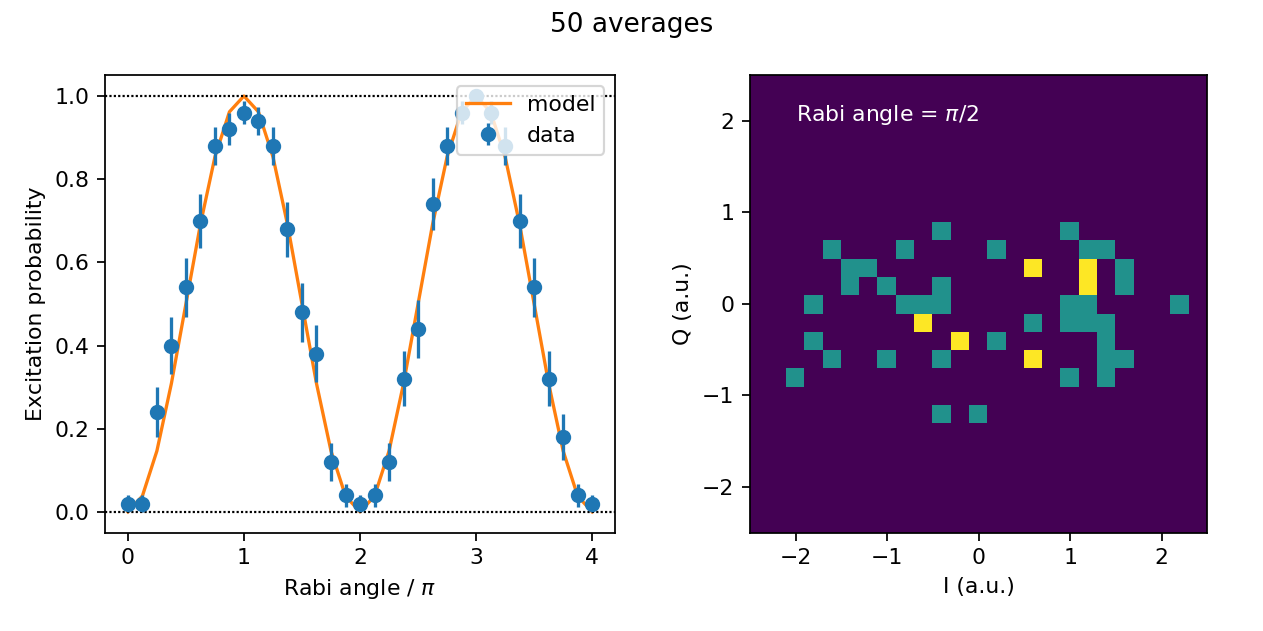

<IPython.core.display.Javascript object>


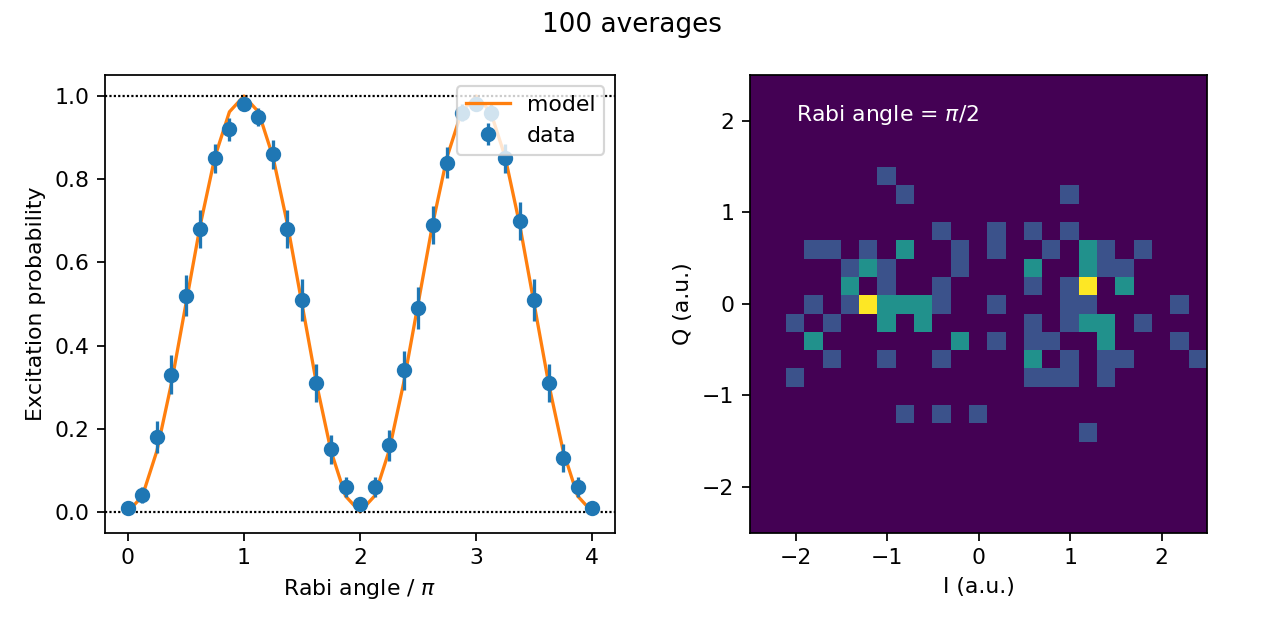

In [7]:
idx = 4 # pi/2

p_data = np.zeros_like(rabi_angles)
err_data = np.zeros_like(rabi_angles)
ideal_rabi = 0.5 - 0.5 * np.cos(rabi_angles) # how the probabilities would ideally look

for navgs in [10, 50, 100]: # pick a few snapshots to show

    for i in range(rabi_angles.size): # compute probability of the real part being left/right of 0
        p_data[i] = np.where(samples[i,:navgs].real > 0)[0].size / float(navgs)
        err_data[i] = ((p_data[i] * (1.-p_data[i]))/navgs)**.5 # statistical uncertainties (from binomial distribution) 

    h, xe, ye = np.histogram2d(samples[idx, :navgs].real, samples[idx, :navgs].imag, 
                               bins=np.linspace(-2.5, 2.5, 26)) # histogram the results

    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    fig.suptitle(f"{navgs} averages")

    ax = axes[0]
    ax.errorbar(rabi_angles/np.pi, p_data, yerr=err_data, fmt='o',
                label='data')
    ax.plot(rabi_angles/np.pi, ideal_rabi, '-', zorder=0,
            label='model')

    ax.set_xlabel(r"Rabi angle / $\pi$")
    ax.set_ylabel("Excitation probability")
    ax.axhline(0, color='k', lw=1, dashes=[1,1])
    ax.axhline(1, color='k', lw=1, dashes=[1,1])
    ax.legend(loc='upper right')

    ax = axes[1]
    im = ax.pcolormesh(xe, ye, h.T)
    ax.set_aspect('equal')
    ax.set_xlabel('I (a.u.)')
    ax.set_ylabel('Q (a.u.)')
    ax.text(-2, 2, r'Rabi angle = $\pi$/2', color='w')

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

# Summary: Basic plotting needs for qubit experiments

* Visualization of complex data
    * plot Re/Im/Abs/Phase as function of arbitrary parameters (might be N-dimensional setpoint space)
    * IQ Histograms of the individual records
    * Select setpoint(s) of which we want to see the complex data
    
* Data processing
    * numerical extraction of new values (like some probability -- but that is only one example!) from the IQ data and plotting those.  Processing methods can be arbitrary, in general.
    * comparison with models
    
* Live plotting
    * dynamic build-up (and analysis!) of data.
    * Both growing the data in terms of setpoints or averages is required.